# ----------------------------------------------------------------------
# BRCA WUSTL SEGMENT only loss RUNS
# ----------------------------------------------------------------------

In [16]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-seg-jl.m2'
patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
partition_file = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-cna-jl.ppf9'
segment_info_file = "/Users/jlu96/maf/new/BRCA_wustl/segment_info_seg.txt"
file_prefix = '/Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl-'
test_minFreq_ratio = 0.1
minPatientPercentile = 15
cpairPercentile = 10
mpairPercentile = 10

In [17]:
# Look at top segments. Same filters.


# Let's try limiting the significant co-occurrent pairs and see if we can increase our power
# Let's consider the 100 least mutated patients and search for co-occurrence within them

import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np


pairfile = file_prefix + 'pairs-min_cohort.txt'
triplet_file_prefix = file_prefix + 'triplet-'
new_pairfile = file_prefix + "-pairs-min_cohort_filtered.txt"
new_cpairfile = file_prefix + "-cpairs-min_cohort_filtered.txt"
new_mpairfile = file_prefix + "-mpairs-min_cohort_filtered.txt"
geneFile = None
minFreq = 0
compute_mutex = True
closer_than_distance = 100000000


numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, minPatientPercentile)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "Smallest cluster patients is ", len(c0patients) 

print "number genes in smallest cluster is ", len(c0genes)

test_minFreq = int( test_minFreq_ratio * len(c0patients))
print "Mutation frequency threshold is ", test_minFreq

print "number of genes above threashold ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])

t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing within the smallest cluster..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "Writing to file...",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
os.system('say "finished"')

Smallest cluster patients is  145
number genes in smallest cluster is  1267
Mutation frequency threshold is  14
number of genes above threashold  106
Number of pairs to test:  4030
Number of pairs is  4030  retrieved in time :  0.307568073273
Getting cooccurrence across the whole distribution
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl-pairs-min_cohort.txt


0

## Plot initial run through, find pairs to test

Top  10 percent of cooccurring pairs:  0.100803562406
Top  10 percent of mutually exclusive pairs :  0.454158205301
Now number of pairs to test  825
Number of genes  102


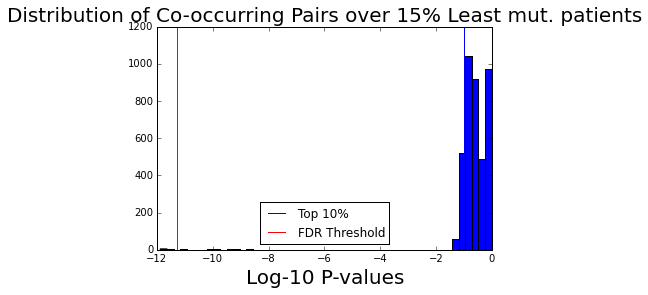

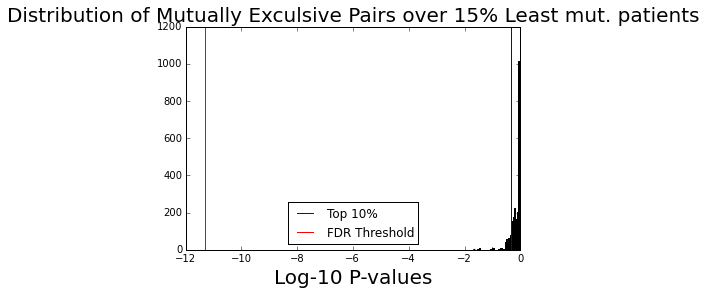

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold or pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of pairs to test ", len(goodpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [20]:
new_pairsdict, new_genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodpairs, compute_mutex=compute_mutex)

print "number of pairs is ", len(new_pairsdict)
print "Testing across the whole distribution"

new_pairsdict = chi.add_BinomP_cohorts_all_pairs(new_pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Writing to file...", new_cpairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)
os.system('say "finished"')

number of pairs is  825
Testing across the whole distribution
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered.txt


0

### Plot results

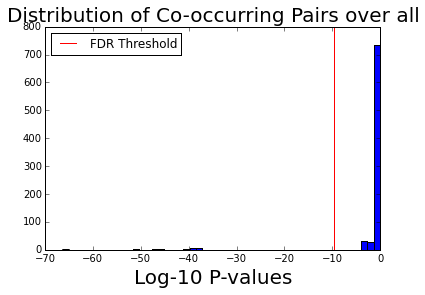

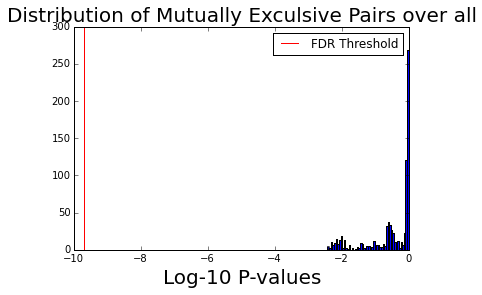

Number significant mutex 0
Number significant coocurr 31


In [21]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_pairsdict[c]['AllCBinomProb'] for c in new_pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_pairsdict[c]['AllMBinomProb'] for c in new_pairsdict])
logmp = np.log10(mpvalues)

cthreshold = 0.05/len(logcp)
mthreshold = 0.05/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs

new_sig_dict = new_pairsdict.copy()
for pair in new_pairsdict:
    if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_dict.pop(pair)
        
# Split into mutex and cooccur
new_sig_m_dict = new_sig_dict.copy()
new_sig_c_dict = new_sig_dict.copy()

for pair in new_sig_dict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_sig_dict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)

## Mutual exclusivity info

In [22]:


bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********MUTUAL EXCLUSIVITY INFO**********\n"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands'])] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands'])] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

## Co-occurrence info

In [23]:
bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********COOCCURRENCE INFO**********\n"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands'])] = set()
    cyto_c_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands'])] = set()
    cyto_c_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
for key in new_sig_c_dict[pair].keys():
    if key not in cfieldnames:
        cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-seg-jl--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
FAM230Closs has 19
RN7SL605Ploss has 12
TBC1D22Aloss has 1
ZNRF3_C22orf31_loss has	1
SEZ6L_RNA5SP495loss has	1
RN7SL757Ploss has 1
AIPL1_FAM64A_KIloss has	1
HS3ST3A1_MIR548loss has	1
MAP2K4_MIR744loss has 1
MYH13_MYH8_MYH4loss has	1
CYB5D1_CHD3_KCNloss has	1
PPM1F_TOP3B_VPRloss has	1
YWHAEloss has 1
IGLL1_GUSBP11_Rloss has	1
LINC00898loss has 1
LARGEloss has 1
RN7SL162P_CHEK2loss has	1
LINC00670_MYOCDloss has	1
MIR4764loss has 1
WSCD1loss has 1
OR11H1_POTEH_KCloss has	1
HMGXB4_TOM1_MIRloss has	1
TXN2_FOXRED2_EIloss has	1
DOC2B_RPH3AL_C1loss has	1
ISXloss has 1
CRK_MYO1C_INPP5loss has	1
STX8_USP43_DHRSloss has	1
DNAH9_ZNF18_RPLloss has	1
MIR3201_FAM19A5loss has	1
TTC28loss has 1
MAPK1_RNA5SP493loss has 1
PEX26_TUBA8_USPloss has	1
MN1_PITPNBloss has 1

**********SINGLE 

0

## Search for triplets

In [24]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    met.writeTriplets(Triplet_dict[t_type], triplet_file_prefix + t_type + '.txt')


number of pairs  31
Pair info of triplets initialized
0  triplets calculated in  0.000658988952637
Including sorting time  0.000786781311035


# ----------------------------------------------------------------------
# BRCA WUSTL SNV RUNS
# ----------------------------------------------------------------------

In [28]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som.m2'
patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
segment_info_file = "/Users/jlu96/maf/new/BRCA_wustl/segment_info_som.txt"
file_prefix = '/Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-'
test_minFreq_ratio = 0.02
minPatientPercentile = 15
cpairPercentile = 10
mpairPercentile = 10

In [29]:
# Look at top segments. Same filters.


# Let's try limiting the significant co-occurrent pairs and see if we can increase our power
# Let's consider the 100 least mutated patients and search for co-occurrence within them

import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np


pairfile = file_prefix + 'pairs-min_cohort.txt'
triplet_file_prefix = file_prefix + 'triplet-'
new_pairfile = file_prefix + "-pairs-min_cohort_filtered.txt"
new_cpairfile = file_prefix + "-cpairs-min_cohort_filtered.txt"
new_mpairfile = file_prefix + "-mpairs-min_cohort_filtered.txt"
geneFile = None
minFreq = 0
compute_mutex = True
closer_than_distance = 100000000


numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, minPatientPercentile)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "Smallest cluster patients is ", len(c0patients) 

print "number genes in smallest cluster is ", len(c0genes)

test_minFreq = int( test_minFreq_ratio * len(c0patients))
print "Mutation frequency threshold is ", test_minFreq

print "number of genes above threashold ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])

t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing within the smallest cluster..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "Writing to file...", pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
os.system('say "finished"')

Smallest cluster patients is  155
number genes in smallest cluster is  2081
Mutation frequency threshold is  3
number of genes above threashold  49
Number of pairs to test:  1132
Number of pairs is  1132  retrieved in time :  0.524853229523
Testing within the smallest cluster...
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-pairs-min_cohort.txt


0

## Plot initial run through, find pairs to test

Top  10 percent of cooccurring pairs:  0.207396554245
Top  10 percent of mutually exclusive pairs :  0.747662312754
Now number of pairs to test  234
Number of genes  49


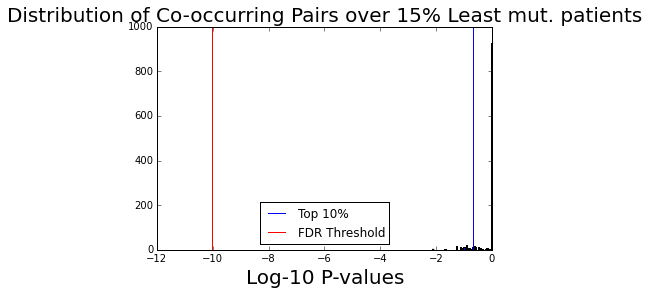

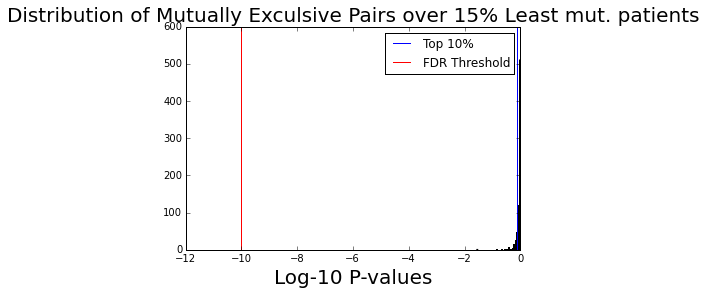

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold or pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of pairs to test ", len(goodpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [31]:
new_pairsdict, new_genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodpairs, compute_mutex=compute_mutex)

print "number of pairs is ", len(new_pairsdict)
print "Testing across the whole distribution"

new_pairsdict = chi.add_BinomP_cohorts_all_pairs(new_pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Writing to file...", new_cpairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)
os.system('say "finished"')

number of pairs is  234
Getting cooccurrence across the whole distribution
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som--cpairs-min_cohort_filtered.txt


0

### Plot results

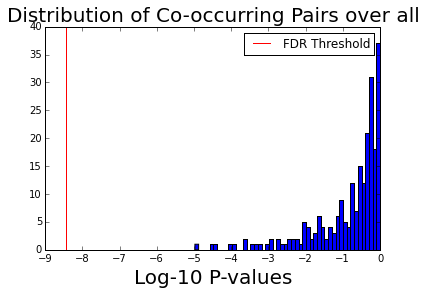

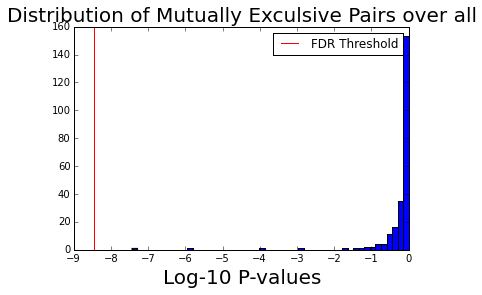

Number significant mutex 3
Number significant coocurr 6


In [32]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_pairsdict[c]['AllCBinomProb'] for c in new_pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_pairsdict[c]['AllMBinomProb'] for c in new_pairsdict])
logmp = np.log10(mpvalues)

cthreshold = 0.05/len(logcp)
mthreshold = 0.05/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs

new_sig_dict = new_pairsdict.copy()
for pair in new_pairsdict:
    if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_dict.pop(pair)
        
# Split into mutex and cooccur
new_sig_m_dict = new_sig_dict.copy()
new_sig_c_dict = new_sig_dict.copy()

for pair in new_sig_dict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_sig_dict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)

## Mutual exclusivity info

In [33]:


bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********MUTUAL EXCLUSIVITY INFO**********\n"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands'])] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands'])] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
TP53 has 3
CDH1 has 1
MAP3K1 has 1
GATA3 has 1

**********SINGLE CYTOBANDS**********
['17p13.1'] has 3
['5q11.2'] has 1
['16q22.1'] has 1
['10p14'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p13.1']"]) has 1
frozenset(["['10p14']", "['17p13.1']"]) has 1
frozenset(["['16q22.1']", "['17p13.1']"]) has 1


0

## Co-occurrence info

In [34]:
bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********COOCCURRENCE INFO**********\n"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands'])] = set()
    cyto_c_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands'])] = set()
    cyto_c_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
for key in new_sig_c_dict[pair].keys():
    if key not in cfieldnames:
        cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
C9orf43 has 2
CACNA1D has 2
SACS has 2
MUC16 has 2
PLCB4 has 1
WNK1 has 1
TTN has 1
MUC5B has 1

**********SINGLE CYTOBANDS**********
['13q12.12'] has 2
['19p13.2'] has 2
['9q31.3'] has 2
['3p21.1'] has 2
['12p13.33'] has 1
['11p15.5'] has 1
['20p12.3', '20p12.2'] has 1
['2q31.2'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['13q12.12']", "['19p13.2']"]) has 1
frozenset(["['19p13.2']", "['2q31.2']"]) has 1
frozenset(["['9q31.3']", "['3p21.1']"]) has 1
frozenset(["['12p13.33']", "['20p12.3', '20p12.2']"]) has 1
frozenset(["['11p15.5']", "['9q31.3']"]) has 1
frozenset(["['13q12.12']", "['3p21.1']"]) has 1


0

## Search for triplets

In [35]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    met.writeTriplets(Triplet_dict[t_type], triplet_file_prefix + t_type + '.txt')


number of pairs  9
Pair info of triplets initialized
0  triplets calculated in  0.000427961349487
Including sorting time  0.000608921051025


# ----------------------------------------------------------------------
# BRCA WUSTL SNV + SEGMENT LOSS RUNS
# ----------------------------------------------------------------------

In [44]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-seg-jl.m2'
patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
segment_info_file = "/Users/jlu96/maf/new/BRCA_wustl/segment_info_som-seg-jl.txt"
file_prefix = '/Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-jl'
test_minFreq_ratio = 0.03
minPatientPercentile = 15
cpairPercentile = 10
mpairPercentile = 10

In [45]:
# Look at top segments. Same filters.


# Let's try limiting the significant co-occurrent pairs and see if we can increase our power
# Let's consider the 100 least mutated patients and search for co-occurrence within them

import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
reload(bgbp)
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np


pairfile = file_prefix + 'pairs-min_cohort.txt'
triplet_file_prefix = file_prefix + 'triplet-'
new_pairfile = file_prefix + "-pairs-min_cohort_filtered.txt"
new_cpairfile = file_prefix + "-cpairs-min_cohort_filtered.txt"
new_mpairfile = file_prefix + "-mpairs-min_cohort_filtered.txt"
geneFile = None
minFreq = 0
compute_mutex = True
closer_than_distance = 100000000


numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, minPatientPercentile)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "Smallest cluster patients is ", len(c0patients) 

print "number genes in smallest cluster is ", len(c0genes)

test_minFreq = int( test_minFreq_ratio * len(c0patients))
print "Mutation frequency threshold is ", test_minFreq

print "number of genes above threashold ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])

t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing within the smallest cluster..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t


print "Writing to file...", pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
os.system('say "finished"')

Smallest cluster patients is  145
number genes in smallest cluster is  4177
Mutation frequency threshold is  4
number of genes above threashold  374
segment  GPR98 not in dictionary. Default to Chromosome Z.
segment  MST1P9 not in dictionary. Default to Chromosome Z.
Number of pairs to test:  63280
Number of pairs is  63280  retrieved in time :  6.46434283257
Getting normal statistics...
Finished in  34.1724498272
Testing within the smallest cluster...
Finished in  63.9560601711
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-jlpairs-min_cohort.txt


0

## Plot initial run through, find pairs to test

Top  10 percent of cooccurring pairs:  0.158455495514
Top  10 percent of mutually exclusive pairs :  0.518582027045
Now number of pairs to test  13245
Number of genes  374


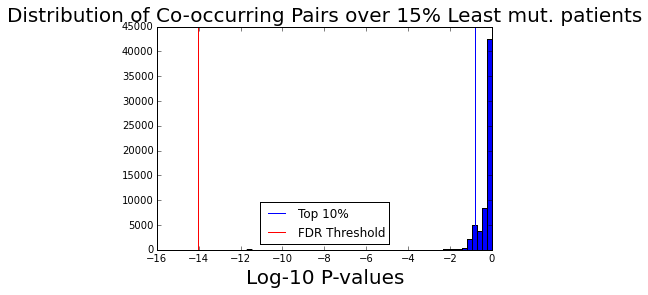

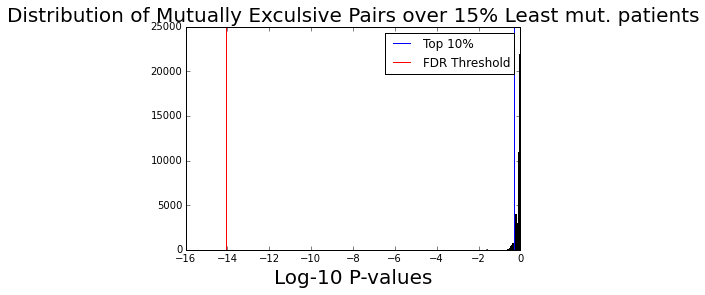

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold or pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of pairs to test ", len(goodpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [47]:
new_pairsdict, new_genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodpairs, compute_mutex=compute_mutex)

print "number of pairs is ", len(new_pairsdict)
print "Testing across the whole distribution"
t = time.time()
new_pairsdict = chi.add_BinomP_cohorts_all_pairs(new_pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t

print "Writing to file...", new_cpairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)
os.system('say "finished"')

number of pairs is  13245
Getting cooccurrence across the whole distribution
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-jl-cpairs-min_cohort_filtered.txt


0

### Plot results

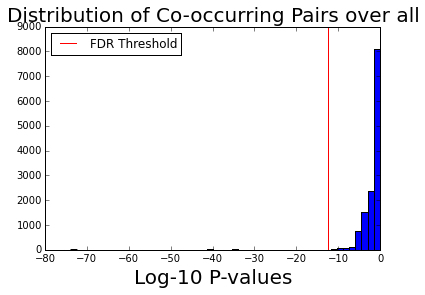

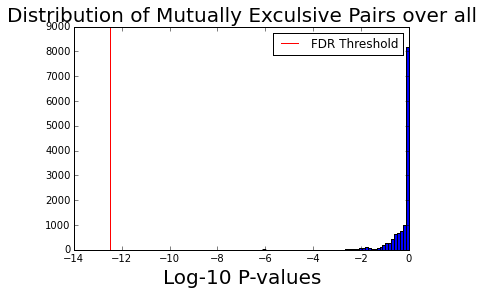

Number significant mutex 4
Number significant coocurr 640


In [48]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_pairsdict[c]['AllCBinomProb'] for c in new_pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_pairsdict[c]['AllMBinomProb'] for c in new_pairsdict])
logmp = np.log10(mpvalues)

cthreshold = 0.05/len(logcp)
mthreshold = 0.05/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs

new_sig_dict = new_pairsdict.copy()
for pair in new_pairsdict:
    if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_dict.pop(pair)
        
# Split into mutex and cooccur
new_sig_m_dict = new_sig_dict.copy()
new_sig_c_dict = new_sig_dict.copy()

for pair in new_sig_dict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_sig_dict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)

## Mutual exclusivity info

In [49]:


bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********MUTUAL EXCLUSIVITY INFO**********\n"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands'])] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands'])] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-jl-mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
MAP3K1 has 3
PIK3CA has 1
MAP2K3loss has 1
SLC5A10_FAM83G_loss has	1
B9D1_MIR1180_MAloss has	1
SCN8A_ANKRD33_Aloss has	1

**********SINGLE CYTOBANDS**********
['5q11.2'] has 3
['17p11.2'] has 3
['12q13.13'] has 1
['3q26.33'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p11.2']"]) has 3
frozenset(["['12q13.13']", "['3q26.33']"]) has 1


0

## Co-occurrence info

In [50]:
bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********COOCCURRENCE INFO**********\n"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands'])] = set()
    cyto_c_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands'])] = set()
    cyto_c_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
for key in new_sig_c_dict[pair].keys():
    if key not in cfieldnames:
        cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-jl-cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
SNORD22loss has 48
FKSG52_PART1_DEloss has	46
PIK3R1_SLC30A5_loss has	41
KCNQ1DNloss has 39
PDE4Dloss has 39
RN7SL811Ploss has 36
NAA38loss has 36
MIR582loss has 33
OR4F17_PPAP2C_Mloss has	32
MAST4_CD180loss has 32
TRPC2_ART5_ART1loss has	29
RN7SL605Ploss has 28
HTR1A_RNF180_RGloss has	28
PLK2_GAPT_MIR54loss has	27
BET1L_SCGB1C1_Oloss has	27
MAP3K1_SETD9_MIloss has	24
TP53 has 24
FAM230Closs has 19
ESM1_GZMK_GZMA_loss has	16
ADM_AMPD3_RNU6Aloss has	15
GALNT18_CSNK2A3loss has 15
SBF2loss has 15
MIR4299_USP47_Dloss has	15
SCN8A_ANKRD33_Aloss has	15
LHX2_NEK6_PSMB7loss has	15
RN7SKP67_DCTD_Floss has	12
ZFP42_TRIML2_TRloss has	11
RN7SKP13loss has 11
TENM3_MIR1305loss has 11
TOPAZ1_TCAIM_LIloss has	10
LINC00290loss has 10
RN7SL253P_GALNTloss has	10
NRG1loss has 9
GFRA2_

0

## Search for triplets

In [60]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    met.writeTriplets(Triplet_dict[t_type], triplet_file_prefix + t_type + '.txt')
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene in genes])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')


number of pairs  644
Pair info of triplets initialized
336  triplets calculated in  0.214642047882
Including sorting time  0.216140031815
336  of type  CooccurringCooccurringCooccurring
Triplets written to  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-jltriplet-CooccurringCooccurringCooccurring.txt_Triplets.tsv
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
KCNQ1DNloss has 128
TP53 has 113
BET1L_SCGB1C1_Oloss has	56
TRPC2_ART5_ART1loss has	55
SCN8A_ANKRD33_Aloss has	54
LHX2_NEK6_PSMB7loss has	54
RN7SL811Ploss has 35
NAA38loss has 35
OR4F17_PPAP2C_Mloss has	30
RN7SL605Ploss has 26
MAP3K1_SETD9_MIloss has	20
MIR582loss has 20
PDE4Dloss has 20
HTR1A_RNF180_RGloss has	20
PLK2_GAPT_MIR54loss has	20
PIK3R1_SLC30A5_loss has	20
ESM1_GZMK_GZMA_loss has	20
FKSG52_PART1_DEloss has	20
MAST4_CD180loss has 20
ADM_AMPD3_RNU6Aloss has	12
GALNT18_CSNK2A3loss has 12
SBF2loss has 12
MIR4299_USP47_Dloss has	12
RN7S

# ----------------------------------------------------------------------
# BRCA WUSTL SNV + SEGMENT GAIN LOSS RUNS
# ----------------------------------------------------------------------

In [16]:
mutationmatrix = '/Users/jlu96/maf/new/BRCA_wustl/BRCA_wustl-som-seg-gl.m2'
patientFile = '/Users/jlu96/maf/new/BRCA_wustl/shared_patients.plst'
segment_info_file = "/Users/jlu96/maf/new/BRCA_wustl/segment_info_som-seg-gl.txt"
file_prefix = '/Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-gl'
test_minFreq_ratio = 0.05
minPatientPercentile = 15
cpairPercentile = 10
mpairPercentile = 10

In [2]:
# Look at top segments. Same filters.


# Let's try limiting the significant co-occurrent pairs and see if we can increase our power
# Let's consider the 100 least mutated patients and search for co-occurrence within them

import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
reload(bgbp)
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np


pairfile = file_prefix + 'pairs-min_cohort.txt'
triplet_file_prefix = file_prefix + 'triplet-'
new_pairfile = file_prefix + "-pairs-min_cohort_filtered.txt"
new_cpairfile = file_prefix + "-cpairs-min_cohort_filtered.txt"
new_mpairfile = file_prefix + "-mpairs-min_cohort_filtered.txt"
geneFile = None
minFreq = 0
compute_mutex = True
closer_than_distance = 100000000


numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, minPatientPercentile)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "Smallest cluster patients is ", len(c0patients) 

print "number genes in smallest cluster is ", len(c0genes)

test_minFreq = int( test_minFreq_ratio * len(c0patients))
print "Mutation frequency threshold is ", test_minFreq

print "number of genes above threashold ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])

t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing within the smallest cluster..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t


print "Writing to file...", pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
os.system('say "finished"')

Not importing the Fortran bipartite_edge_swap bindings in permute.py.
Smallest cluster patients is  145
number genes in smallest cluster is  6281
Mutation frequency threshold is  7
number of genes above threashold  731
Number of pairs to test:  234222
Number of pairs is  234222  retrieved in time :  13.5679411888
Getting normal statistics...
Finished in  405.842004061
Testing within the smallest cluster...
Finished in  344.023331881
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-glpairs-min_cohort.txt


0

## Plot initial run through, find pairs to test

Top  10 percent of cooccurring pairs:  0.182634792957
Top  10 percent of mutually exclusive pairs :  0.201509302185
Now number of pairs to test  47502
Number of genes  729


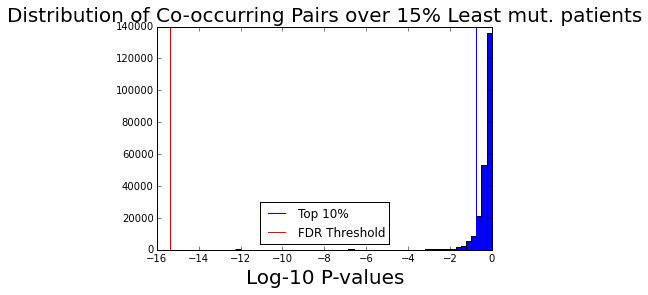

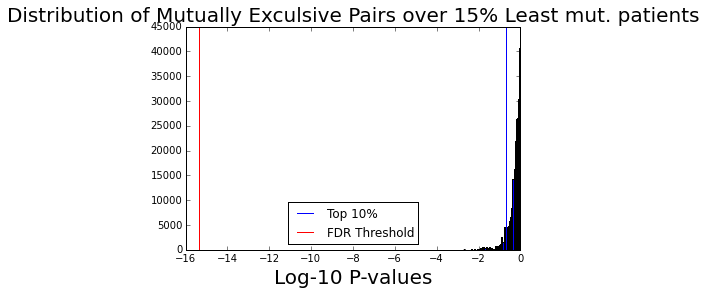

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold or pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of pairs to test ", len(goodpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.axvline(x=np.log(threshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [18]:
new_pairsdict, new_genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodpairs, compute_mutex=compute_mutex)

print "number of pairs is ", len(new_pairsdict)
print "Testing across the whole distribution"
t = time.time()
new_pairsdict = chi.add_BinomP_cohorts_all_pairs(new_pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t

print "Writing to file...", new_cpairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)
os.system('say "finished"')

number of pairs is  47502
Testing across the whole distribution
Finished in  62.5590908527
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-gl-cpairs-min_cohort_filtered.txt


0

### Plot results

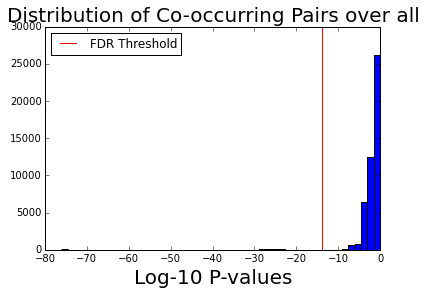

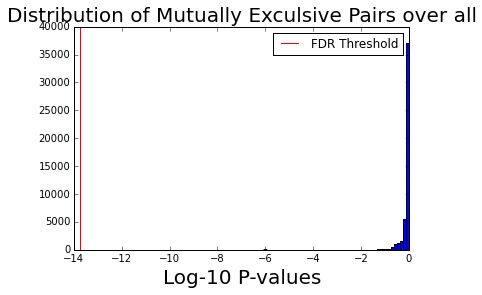

Number significant mutex 1
Number significant coocurr 1731


In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_pairsdict[c]['AllCBinomProb'] for c in new_pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_pairsdict[c]['AllMBinomProb'] for c in new_pairsdict])
logmp = np.log10(mpvalues)

cthreshold = 0.05/len(logcp)
mthreshold = 0.05/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exculsive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs

new_sig_dict = new_pairsdict.copy()
for pair in new_pairsdict:
    if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_dict.pop(pair)
        
# Split into mutex and cooccur
new_sig_m_dict = new_sig_dict.copy()
new_sig_c_dict = new_sig_dict.copy()

for pair in new_sig_dict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_sig_dict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)

## Mutual exclusivity info

In [20]:


bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********MUTUAL EXCLUSIVITY INFO**********\n"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands'])] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands'])] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-gl-mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
B9D1_MIR1180_MAloss has	1
MAP3K1 has 1

**********SINGLE CYTOBANDS**********
['5q11.2'] has 1
['17p11.2'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['5q11.2']", "['17p11.2']"]) has 1


0

## Co-occurrence info

In [21]:
bgbp.write_segment_infos(goodgenes, segment_info_file)


print "*********COOCCURRENCE INFO**********\n"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands'])] = set()
    cyto_c_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands'])] = set()
    cyto_c_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
for key in new_sig_c_dict[pair].keys():
    if key not in cfieldnames:
        cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile



# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-gl-cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
RN7SL811Pgain has 82
RN7SL371Pgain has 82
NAA38gain has 82
ARC_JRK_PSCA_LYgain has	67
TRAPPC9gain has 57
C8orf17_CHRAC1_gain has	56
SNORD22loss has 55
KCNK9gain has 55
FAM135B_COL22A1gain has 46
SNORA44gain has 45
ZFAT_MIR30B_MIRgain has	45
KHDRBS3gain has 45
PTPRN2_MIR595_Mgain has	36
EFR3A_OC90_HHLAgain has	36
ADCY8gain has 35
RNF32_LMBR1_NOMgain has	34
OR4F21_RPL23AP5loss has	33
PAXIP1_HTR5A_RNgain has	32
DLGAP2_CLN8_MIRloss has	32
ASAP1gain has 32
RNA5SP251loss has 31
DPP6gain has 31
FABP5P3_RNA5SP2gain has	30
KMT2Cgain has 30
CSMD1loss has 29
RN7SL318P_RN7SKloss has	28
MIR548F4_RNA5SPgain has	27
RN7SL72P_C7orf3gain has	27
RN7SL178P_CLDN2loss has	26
FAM20C_PDGFA_PRgain has	26
RN7SL605Ploss has 26
DEFA1_DEFA1B_DEloss has	26
ERI1_MIR4660_PPloss has	26
MAD1L1_MIR4

0

## Search for triplets

In [22]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    met.writeTriplets(Triplet_dict[t_type], triplet_file_prefix + t_type + '.txt')
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene in genes])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')


number of pairs  1732
Pair info of triplets initialized
1429  triplets calculated in  0.790498971939
Including sorting time  0.793482065201
1429  of type  CooccurringCooccurringCooccurring
Triplets written to  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/BRCA_wustl-som-seg-gltriplet-CooccurringCooccurringCooccurring.txt_Triplets.tsv
*********CooccurringCooccurringCooccurringINFO**********


**********SINGLE GENES**********
RN7SL811Pgain has 549
RN7SL371Pgain has 549
NAA38gain has 549
PTPRN2_MIR595_Mgain has	102
RNF32_LMBR1_NOMgain has	96
PAXIP1_HTR5A_RNgain has	90
DPP6gain has 87
KMT2Cgain has 84
FABP5P3_RNA5SP2gain has	84
RN7SL72P_C7orf3gain has	75
MIR548F4_RNA5SPgain has	75
FAM20C_PDGFA_PRgain has	72
MAD1L1_MIR4655_gain has	72
CNTNAP2gain has 72
SDK1gain has 69
FOXK1_AP5Z1_MIRgain has	66
CREB3L2_AKR1D1_gain has	63
CHRM2_MIR490_PTgain has	60
NDUFA4_PHF14gain has 60
THSD7A_TMEM106Bgain has	54
EXOC4_LRGUK_SLCgain has	54
AGMO_MEOX2gain has 51
ETV1gain has 51
H